In [1]:
import datetime as dt
import itertools
from pathlib import Path

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import seaborn as sns
import xarray as xr

from remake import load_remake

from mcs_prime import McsTracks, PATHS
from mcs_prime.util import update_progress
%matplotlib inline

In [2]:
mle = load_remake('../../remakefiles/mcs_local_envs.py')

loading pixel inputs cache

TODOS
* Make sure filenames are consistent
* Make sure variables names are sensible/consistent
* Docstrings for all fns, classes
* Validate all data
* Consistent attrs for all created .nc files
* Units on data vars etc.



In [3]:
t = mle.LifecycleMcsLocalEnvHist.tasks[0]

In [4]:
ds = xr.open_dataset(t.outputs['lifecycle_mcs_local_env'])
ds = ds.isel(times=slice(0, 60))

In [5]:
ds.hist_cape.load()
ds.hist_tcwv.load()
ds.hist_shear_0.load()
ds.hist_vertically_integrated_moisture_flux_div.load()

ds.mean_cape.load()
ds.mean_tcwv.load()
ds.mean_shear_0.load()
ds.mean_vertically_integrated_moisture_flux_div.load()

<xarray.DataArray 'mean_vertically_integrated_moisture_flux_div' (tracks: 2406,
                                                                  radius: 5,
                                                                  times: 60)>
array([[[-2.64202522e-04, -1.32595071e-04, -1.30803940e-04, ...,
                     nan,             nan,             nan],
        [-3.28279990e-04, -2.71716688e-04, -2.28420079e-04, ...,
                     nan,             nan,             nan],
        [-2.85847578e-04, -3.05938895e-04, -2.57134788e-04, ...,
                     nan,             nan,             nan],
        [-1.47535744e-04, -1.31337069e-04, -1.14346741e-04, ...,
                     nan,             nan,             nan],
        [-1.23307910e-04, -1.11101675e-04, -8.96531427e-05, ...,
                     nan,             nan,             nan]],

       [[ 5.14847422e-05,  1.84380000e-05, -1.59212382e-04, ...,
                     nan,             nan,             nan],
        [ 4.26675611e-06, -5.05523748e-05, -1.71382098e-04, ...,
                     nan,             nan,             nan],
        [-5.91253788e-05, -1.27189290e-04, -2.03890772e-04, ...,
                     nan,             nan,             nan],
        [-6.79371750e-05, -6.77954885e-05, -6.63678159e-05, ...,
                     nan,             nan,             nan],
        [ 1.74458638e-05,  1.69736072e-05,  9.96692006e-06, ...,
...
                     nan,             nan,             nan],
        [-4.19025531e-04, -4.86513610e-04, -4.10911424e-04, ...,
                     nan,             nan,             nan],
        [-3.77984188e-04, -3.68634507e-04, -2.73327849e-04, ...,
                     nan,             nan,             nan],
        [-2.15058298e-04, -1.83483762e-04, -1.36567949e-04, ...,
                     nan,             nan,             nan],
        [-5.47864112e-05, -5.11855227e-05, -4.44933586e-05, ...,
                     nan,             nan,             nan]],

       [[ 2.59972755e-05,  1.19422698e-04,  3.42409231e-06, ...,
         -2.02287135e-03, -8.49077554e-04, -1.27980804e-03],
        [ 4.08617595e-05,  5.01229909e-05, -5.75380069e-05, ...,
         -7.87116943e-04, -8.38079618e-04, -8.17997613e-04],
        [ 6.23105205e-05,  2.34964858e-05, -1.04214325e-04, ...,
         -3.38360848e-04, -3.55482861e-04, -3.97133667e-04],
        [-5.37809404e-05, -6.66277024e-05, -7.80591488e-05, ...,
         -1.83012829e-05, -2.68787703e-05, -9.25291457e-05],
        [ 8.78421944e-06,  5.78995595e-06,  9.56846392e-07, ...,
          1.14770640e-05,  9.52695614e-06,  1.87714273e-05]]])
Coordinates:
  * tracks   (tracks) int64 0 1 2 3 4 5 6 ... 2399 2400 2401 2402 2403 2404 2405
  * radius   (radius) int64 1 100 200 500 1000
  * times    (times) int64 -24 -23 -22 -21 -20 -19 -18 ... 29 30 31 32 33 34 35

In [6]:
def plot_precursor_mean_val(ds, var, N=60):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches((20, 8))
    for r in [100, 200, 500, 1000]:
        data = ds[f'mean_{var}'].sel(radius=r).isel(times=slice(0, N)).mean(dim='tracks')
        ax1.plot(range(-24, -24 + N), data, label=r)
        
    hist_data = ds[f'hist_{var}'].sel(radius=100).isel(times=slice(0, N))
    ax2.plot(range(-24, -24 + N), np.isnan(hist_data.values).sum(axis=(0, 1)))
    ax1.legend()
    for ax in [ax1, ax2]:
        ax.axvline(x=0)

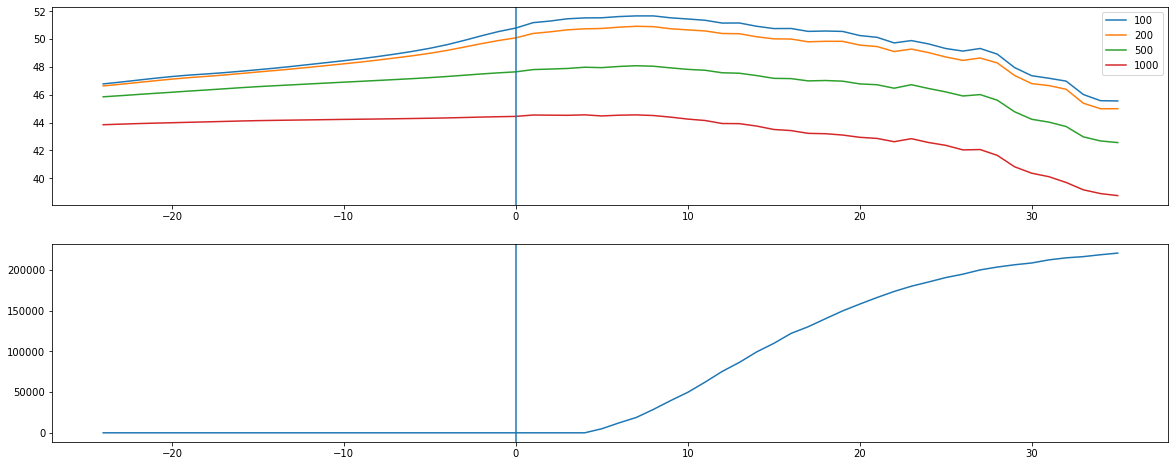

In [7]:
plot_precursor_mean_val(ds, 'tcwv')

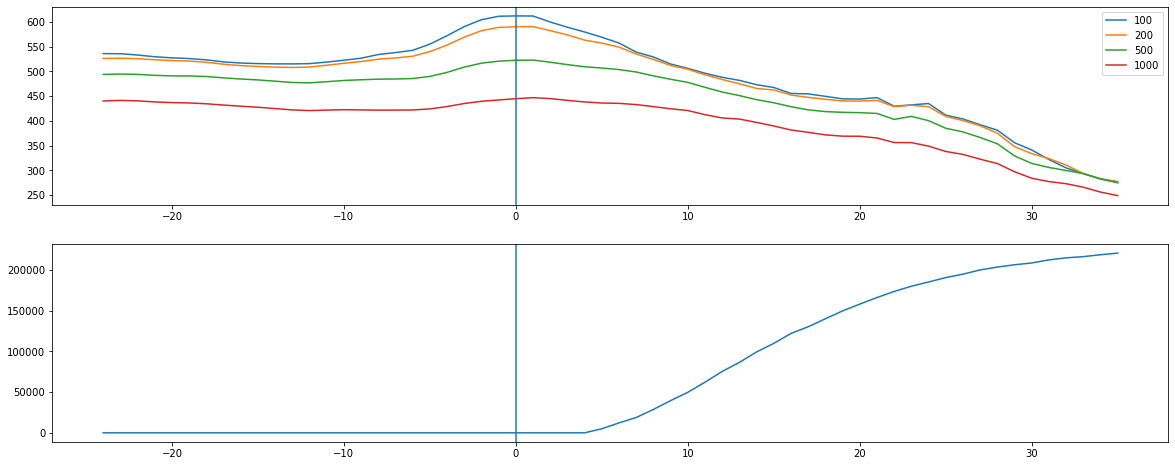

In [9]:
plot_precursor_mean_val(ds, 'cape')

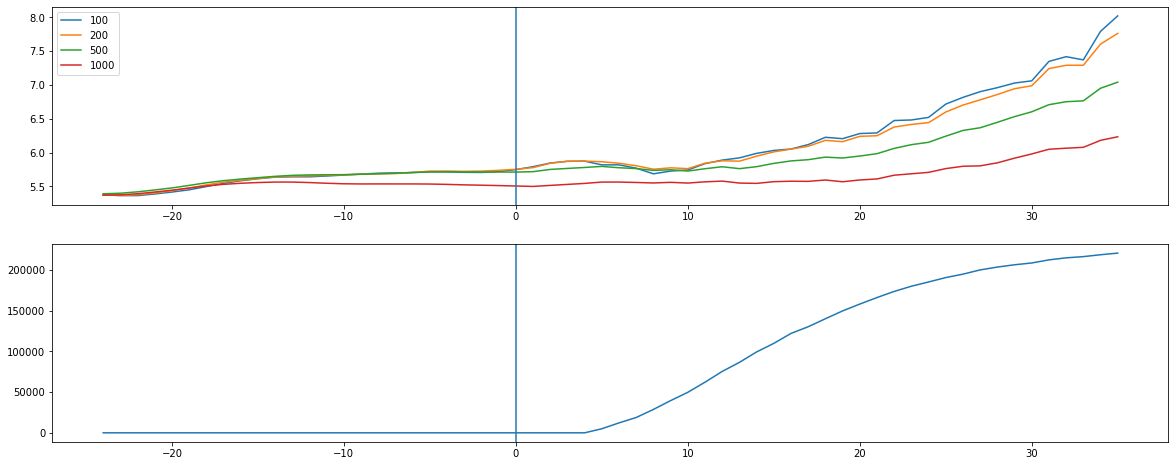

In [10]:
plot_precursor_mean_val(ds, 'shear_0')

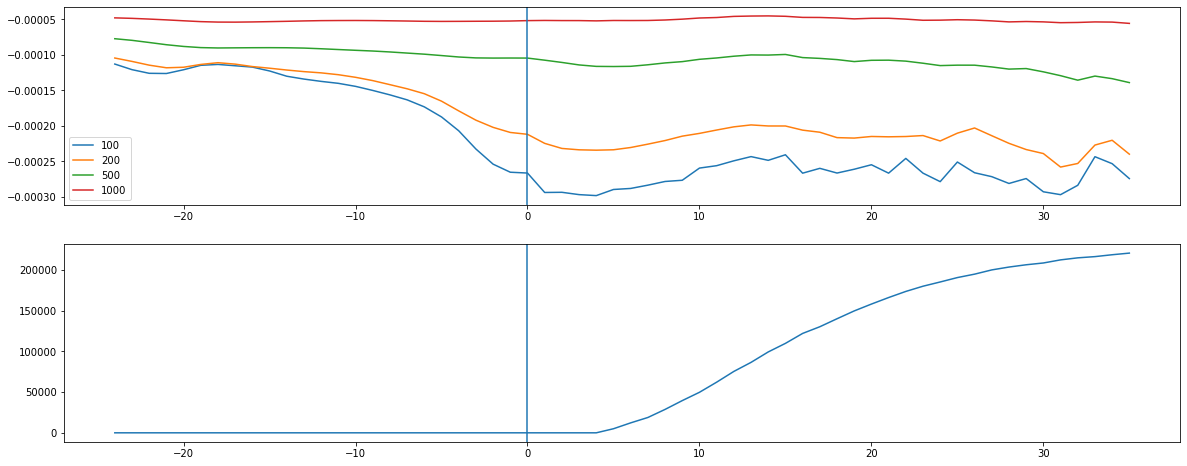

In [11]:
plot_precursor_mean_val(ds, 'vertically_integrated_moisture_flux_div')

In [ ]:
def plot_precursor_dists(ds, var, radius=500):
    palette = sns.color_palette('viridis', 24)
    hist = ds[f'hist_{var}'].sel(radius=radius).isel(times=slice(0, 24)).mean(dim='tracks').values

    # plot_data = ds[var].sel(radius=radius, times=slice(0, 23)).mean(dim='tracks').values
    fig = plt.figure(figsize=(20, 7))
    for c, i in zip(palette, range(hist.shape[1])):
        plt.plot(ds[f'{var}_hist_mids'].values, hist[:, i] / hist[:, i].sum(), color=c, label=i - 24)
    if var ==  'cape':
        if True:
            plt.gca().set_yscale('log')
            plt.ylim((1e-3, None))
        else:
            
            if radius == 100:
                plt.ylim((0, 3))
            elif radius == 200:
                plt.ylim((0, 12))
            elif radius == 500:
                plt.ylim((0, 60))
            elif radius == 1000:
                plt.ylim((0, 240))

    if var == 'cape':
        plt.xlim((0, 2000))
    plt.legend()

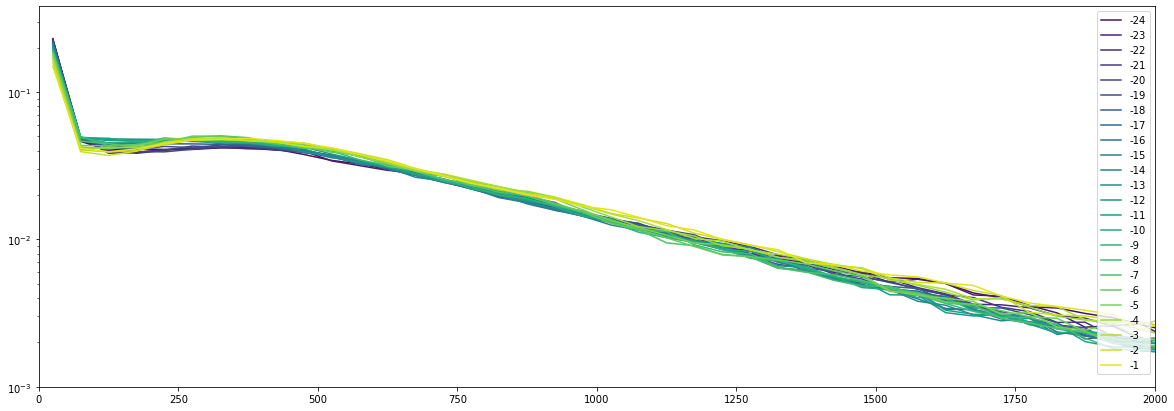

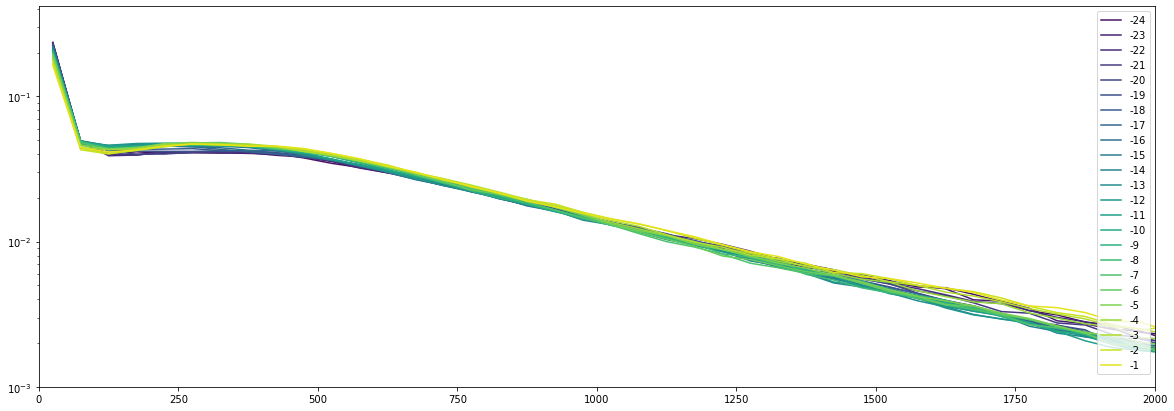

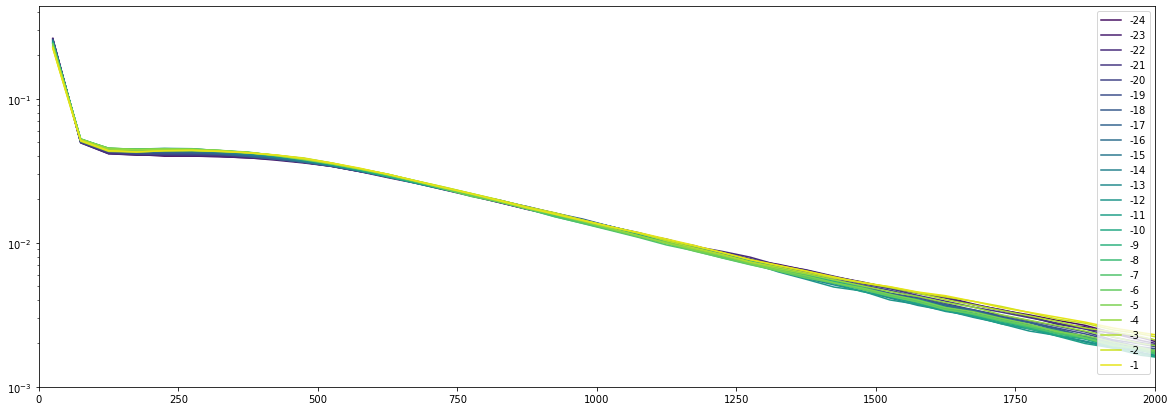

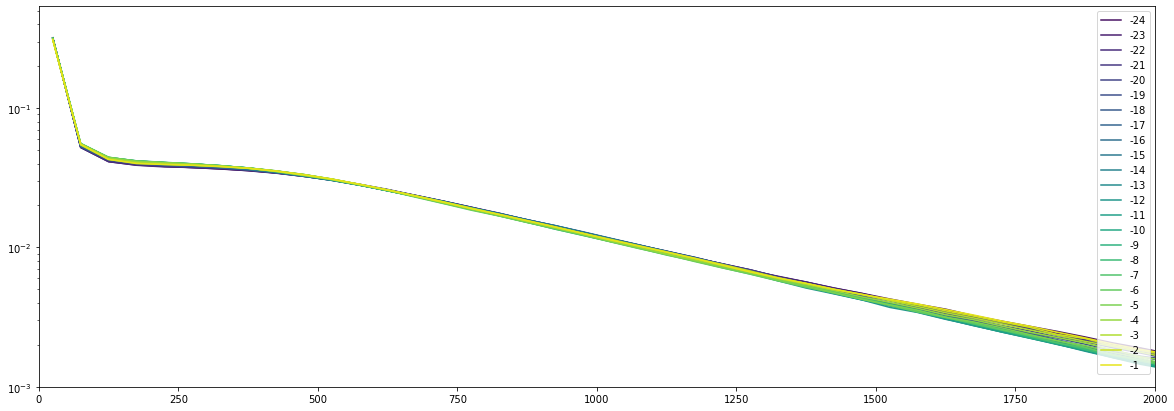

In [7]:
for r in [100, 200, 500, 1000]:
    plot_precursor_dists(ds, 'cape', r)


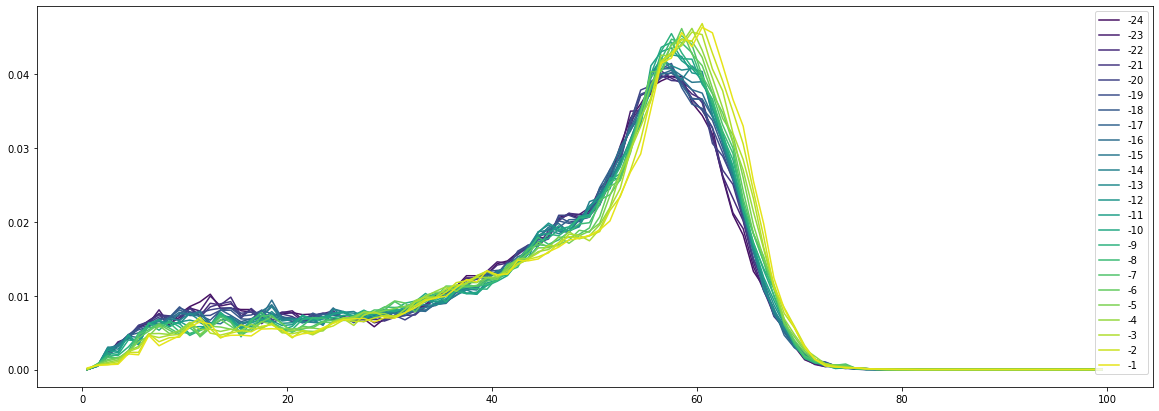

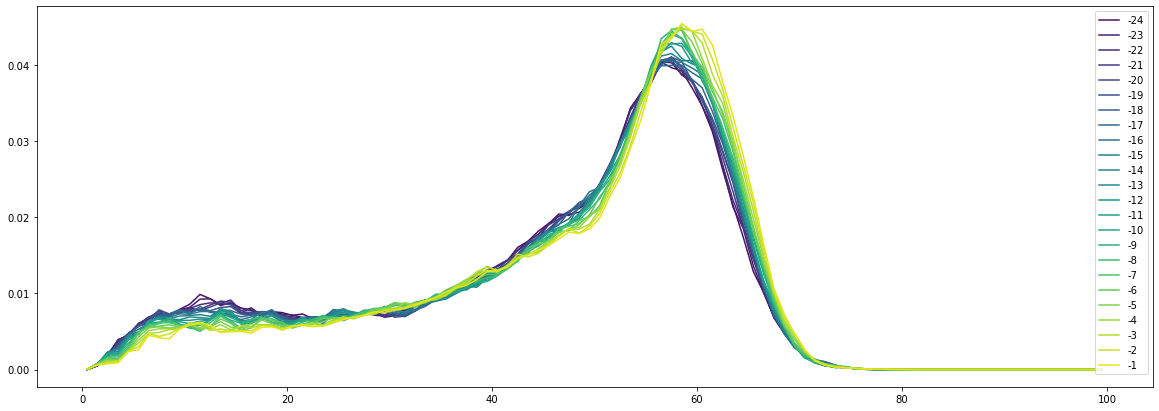

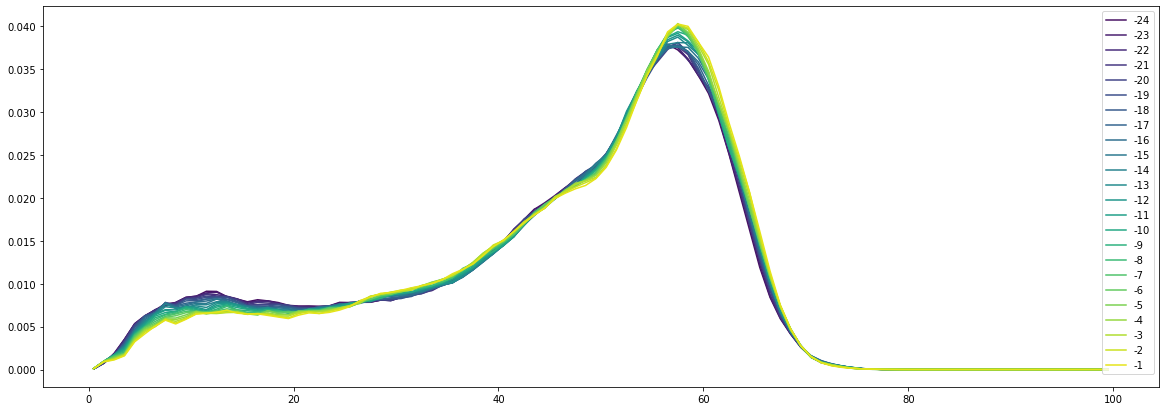

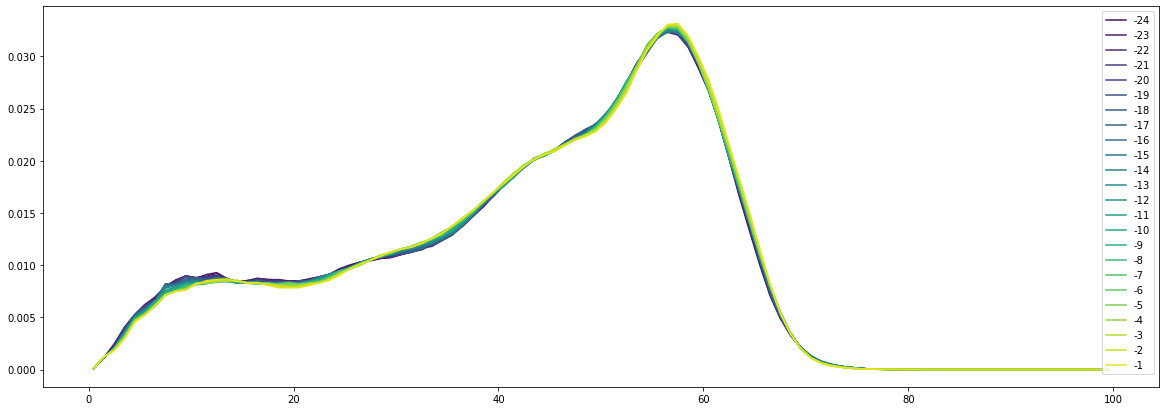

In [8]:
for r in [100, 200, 500, 1000]:
    plot_precursor_dists(ds, 'tcwv', r)

In [12]:
# Edit these based on where these are on your system.
statsdir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats')

In [13]:
stats_paths = sorted(statsdir.glob('mcs_tracks_final_extc_????????.0000_????????.0000.nc'))
print(stats_paths[0])
print(stats_paths[-1])

/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20000601.0000_20010101.0000.nc
/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20200101.0000_20210101.0000.nc


In [14]:
tracks = McsTracks.open(stats_paths[-1])

In [15]:
tracks

McsTracks[2020-01-01 00:30:00, 2020-12-31 22:30:00, ntracks=32138]

In [16]:
mcs_start_times = pd.DatetimeIndex(tracks.dstracks.start_basetime.values)

In [17]:
dstracks_jan = tracks.dstracks.isel(tracks=(mcs_start_times.month == 1))

In [18]:
dstracks_jan

<xarray.Dataset>
Dimensions:                  (tracks: 2406, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 2402 2403 2404 2405
  * times                    (times) int64 0 1 2 3 4 5 ... 395 396 397 398 399
  * mergers                  (mergers) int64 0 1 2 3 4 5 6 ... 44 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 ...
    start_status             (tracks) float64 ...
    end_status               (tracks) float64 ...
    start_basetime           (tracks) datetime64[ns] 2020-01-01T00:30:00 ... ...
    end_basetime             (tracks) datetime64[ns] 2020-01-01T11:30:00 ... ...
    start_split_cloudnumber  (tracks) float64 ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 ...
    movement_distance        (tracks, times) float32 ...
    movement_speed           (tracks, times) float32 ...
    movement_theta           (tracks, times) float32 ...
    movement_distance_x      (tracks, times) float32 ...
    movement_distance_y      (tracks, times) float32 ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [19]:
ds

<xarray.Dataset>
Dimensions:                                             (tracks: 2406,
                                                         radius: 5,
                                                         cape_hist_mids: 100,
                                                         times: 424,
                                                         percentile: 5,
                                                         tcwv_hist_mids: 100,
                                                         ...
                                                         cape_bins: 101,
                                                         tcwv_bins: 101,
                                                         shear_0_bins: 101,
                                                         shear_1_bins: 101,
                                                         shear_2_bins: 101,
                                                         vertically_integrated_moisture_flux_div_bins: 101)
Coordinates: (12/16)
  * tracks                                              (tracks) int64 0 ... ...
  * radius                                              (radius) int64 1 ... ...
  * times                                               (times) int64 -24 ......
  * percentile                                          (percentile) int64 10...
  * cape_hist_mids                                      (cape_hist_mids) float64 ...
  * cape_bins                                           (cape_bins) float64 0...
    ...                                                  ...
  * shear_1_hist_mids                                   (shear_1_hist_mids) float64 ...
  * shear_1_bins                                        (shear_1_bins) float64 ...
  * shear_2_hist_mids                                   (shear_2_hist_mids) float64 ...
  * shear_2_bins                                        (shear_2_bins) float64 ...
  * vertically_integrated_moisture_flux_div_hist_mids   (vertically_integrated_moisture_flux_div_hist_mids) float64 ...
  * vertically_integrated_moisture_flux_div_bins        (vertically_integrated_moisture_flux_div_bins) float64 ...
Data variables: (12/18)
    hist_cape                                           (tracks, radius, cape_hist_mids, times) float64 ...
    mean_cape                                           (tracks, radius, times) float64 ...
    percentile_cape                                     (tracks, radius, percentile, times) float64 ...
    hist_tcwv                                           (tracks, radius, tcwv_hist_mids, times) float64 ...
    mean_tcwv                                           (tracks, radius, times) float64 ...
    percentile_tcwv                                     (tracks, radius, percentile, times) float64 ...
    ...                                                  ...
    hist_shear_2                                        (tracks, radius, shear_2_hist_mids, times) float64 ...
    mean_shear_2                                        (tracks, radius, times) float64 ...
    percentile_shear_2                                  (tracks, radius, percentile, times) float64 ...
    hist_vertically_integrated_moisture_flux_div        (tracks, radius, vertically_integrated_moisture_flux_div_hist_mids, times) float64 ...
    mean_vertically_integrated_moisture_flux_div        (tracks, radius, times) float64 ...
    percentile_vertically_integrated_moisture_flux_div  (tracks, radius, percentile, times) float64 ...

In [20]:
max_areas = np.nanmax(dstracks_jan.area.values, axis=1)


In [21]:
max_area_thresh = np.percentile(max_areas, [25, 50, 75])


In [22]:
max_area_thresh
max_area_bins = np.array([0] + list(max_area_thresh) + [1e7])

In [23]:
def gen_mask(field, bins):
    mask = np.zeros((len(ds.tracks), len(bins) - 1), dtype=bool)
    for i in range(len(bins) - 1):
        mask[:, i] = ((field > bins[i]) & (field <= bins[i + 1]))
    return mask

In [24]:
max_area_mask = gen_mask(max_areas, max_area_bins)

In [25]:
max_area_masks.sum(axis=0)

NameError: name 'max_area_masks' is not defined

In [ ]:
def plot_precursor_mean_val_with_mask(ds, var, mask, bins, r=200, N=60):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches((20, 8))
    data = ds[f'mean_{var}'].sel(radius=r).isel(times=slice(0, N))
    for i in range(mask.shape[1]):
        print(i)
        plot_data = data.isel(tracks=mask[:, i]).mean(dim='tracks')
        label = f'{bins[i]} - {bins[i + 1]}'
        ax1.plot(range(-24, -24 + N), plot_data, label=label)
    ax1.legend()
        
    for ax in [ax1]:
        ax.axvline(x=0)

In [ ]:
plot_precursor_mean_val_with_mask(ds, 'cape', max_area_masks, max_area_bins)

In [ ]:
plot_precursor_mean_val_with_mask(ds, 'tcwv', max_area_masks, max_area_bins)

In [ ]:
meanlats = np.nanmean(dstracks_jan.meanlat.values, axis=1)

In [ ]:
lat_bins = [-61, -40, -20, 20, 40, 60]
lat_mask = gen_mask(meanlats, lat_bins)

In [ ]:
plot_precursor_mean_val_with_mask(ds, 'cape', lat_mask, lat_bins)

In [ ]:
plot_precursor_mean_val_with_mask(ds, 'tcwv', lat_mask, lat_bins)

In [ ]:
durations = dstracks_jan.track_duration.values
duration_bins = [0, 12, 24, 400]
duration_mask = gen_mask(durations, duration_bins)

In [ ]:
plot_precursor_mean_val_with_mask(ds, 'cape', duration_mask, duration_bins)